<a href="https://colab.research.google.com/github/DexterfreaK/XGboostUrban/blob/master/XGBoost_using_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install gdal

In [ ]:
from osgeo import gdal
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


In [ ]:
# All features in X imported and read as Array
popden = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/popden.tif")
popden = popden.ReadAsArray()

Slope = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/slope.tif")
Slope = Slope.ReadAsArray()

Friction = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/friction.tif")
Friction = Friction.ReadAsArray()

Elevation = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/elevation.tif")
Elevation = Elevation.ReadAsArray()


gdp2005 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/gdp2005.tif")
gdp2005 = gdp2005.ReadAsArray()

floods = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/floods.tif")
floods = floods.ReadAsArray()

accessibility = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/accessibility.tif")
accessibility = accessibility.ReadAsArray()

builtup_05_06 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/05_06_builtup.tif")
builtup_05_06 = builtup_05_06.ReadAsArray()

# Required Shape checking for All features
assert Slope.shape == popden.shape == Friction.shape == Elevation.shape == gdp2005.shape == floods.shape == accessibility.shape == builtup_05_06.shape

(l,w) = Slope.shape

# Reshaping the image to be a 1d Array
Slope = np.reshape(Slope, (l*w,1))
popden = np.reshape(popden, (l*w,1))
Friction = np.reshape(Friction, (l*w,1))
Elevation = np.reshape(Elevation, (l*w,1))
floods = np.reshape(floods, (l*w,1))
accessibility = np.reshape(accessibility, (l*w,1))
builtup_05_06 = np.reshape(builtup_05_06, (l*w,1))
gdp2005 = np.reshape(gdp2005, (l*w,1))


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
#Opening and Reading Y data
Subtracted_builtup_05_06 = gdal.Open("/content/drive/MyDrive/AdjustedData_23_metre_Resolution/11_12_builtup.tif")
Subtracted_builtup_05_06 = Subtracted_builtup_05_06.ReadAsArray()

assert Subtracted_builtup_05_06.shape == (l,w)

#Opening and Reshaping the data
Subtracted_builtup_05_06 = np.reshape(Subtracted_builtup_05_06, (l*w,1))

In [ ]:
# Converting the array data to dataframe for both X and Y
df = pd.DataFrame({
    'Slope': Slope.flatten(),
    'Elevation': Elevation.flatten(),
    'PopDen': popden.flatten(),
    'Friction': Friction.flatten(),
    'Floods': floods.flatten(),
    'Accessibility': accessibility.flatten(),
    'Gdp2005': gdp2005.flatten(),
    'builtup_05_06': builtup_05_06.flatten(),
    'Y_Subtracted_builtup_11_05': Subtracted_builtup_05_06.flatten(),
})


In [ ]:
df.describe()

,Slope,Elevation,PopDen,Friction,Floods,Accessibility,Gdp2005,builtup_05_06,Y_Subtracted_builtup_11_05
count,3.331200e+06,3.331200e+06,3.256383e+06,3.331200e+06,3.331200e+06,3.331200e+06,2.002123e+06,3.331200e+06,3.331200e+06
mean,NaN,-inf,7.454635e-02,-inf,-inf,-inf,1.777354e-01,7.026747e-02,7.125600e-02
std,inf,inf,1.540960e-01,inf,inf,inf,2.715401e-01,2.555973e-01,2.572520e-01
min,-3.402823e+38,-3.402823e+38,0.000000e+00,-3.402823e+38,-3.402823e+38,-3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.433329e-01,8.701493e-01,0.000000e+00,8.396575e-01,-3.402823e+38,7.584229e-01,1.772051e-02,0.000000e+00,0.000000e+00
50%,9.840268e-01,9.253731e-01,0.000000e+00,9.809301e-01,3.482746e-01,9.119344e-01,4.634973e-02,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,8.384361e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.996024e-01,0.000000e+00,0.000000e+00
max,3.400000e+38,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
# dropping Y from X
X = df.drop('Y_Subtracted_builtup_11_05', axis=1)
Y = df['Y_Subtracted_builtup_11_05']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .80)

In [ ]:
params = {
            'max_depth': 6,
            'learning_rate': .01,
        }

xgb_model=XGBClassifier(**params)
model=xgb_model.fit(X_train,y_train)

In [ ]:
# Predicting the Test set results
y_pred = model.predict(X_test)

In [ ]:
#Import some metrics.
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("Precision = {}".format(precision_score(y_test, y_pred, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_pred, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))


Precision = 0.9554325353509667
Recall = 0.9306795363521796
Accuracy = 0.9851029658981748


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

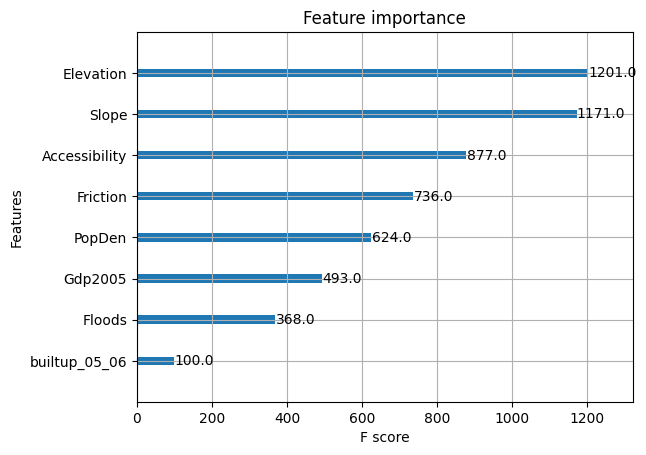

In [ ]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [ ]:
y_pred = model.predict(X)

In [ ]:
y_pred = np.reshape(y_pred,(l,w))
y_pred.shape

(1200, 2776)